# **Generative Adversarial Networks (GANs)**

---

## 0. Recommended Reading + Notebook Configuration

**Required Reading**

1. [Goodfellow et al 2014](https://arxiv.org/pdf/1406.2661.pdf)
2. [Style GAN](https://arxiv.org/pdf/1812.04948.pdf)

**Additional Reading**

1. [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)
2. [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf)
3. [Improved Wasserstain GAN](https://arxiv.org/pdf/1704.00028.pdf)
4. [BigGAN](https://arxiv.org/pdf/1809.11096.pdf)
5. [Progressive GAN](https://arxiv.org/pdf/1710.10196.pdf)
6. [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf)
7. [SRGAN](https://arxiv.org/pdf/1609.04802.pdf)

Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for presenting this notebook:

````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for viewing this notebook:

````
jt -t grade3 -cellw=90% -fs=14 -tfs=14 -ofs=14
````

[Collapsable Notebook Sections](https://forums.fast.ai/t/useful-jupyter-notebook-tips-plugins-collapsible-sections/17919)

In [30]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## 1. Ian Goodfellow Invents GANs

---

In 2014, graduate student Ian Goodfellow published this paper where he showed, that if under a certain set of assumptions, you solved the equation below, you could create fake data that was completely indistinguishable from real data. 

![](../graphics/goodfellow_gans_2014-01.png)

Now, as is the case for many other interesting equations, we humans have no idea how to actually solve this equation in all but the most trivial cases. However, we have found some algorithms that allow us to compute approximate solutions. Goodfellow published one such algorithm in his paper, and using this approach, generated fake images that look…kinda crappy:



![](../graphics/goodfellow_synthetic_images.png)

So why are we talking about a 2014 paper that presents an equation for generating fake data that no one knows how to solve, and an algorithm that allows us to compute poor approximate solutions? Well, if we jump forward 5 years to 2019, Ian Goodfellow is now a director of machine learning at Apple, and the approximate solutions to his equation have gotten better. A lot better. Which of these three images do you think is fake?

![](../graphics/who_is_fake-01.png)

![](../graphics/spacer_small.png)

---

The answer is…all three. None of these are images of people. Further, clever variants of Goodfellow’s idea have been used to do all kinds of other cool stuff, such as: 

- Fill in missing parts of images
- Transform low-resolution images in realistic high-resolution versions (super resolution)
- Generate captions from images
- Generate images from captions 
- Compose interesting music
- Synthesize raw audio
- Synthetically age faces in images
- Make fake videos of real people dancing
- Generate training data for other machine learning models
- Predict depth maps from images
- Find anomalies in medical images
- Compute the mapping from the style of one video to another

Pretty crazy, right? Goodfellow called his approach a generative adversarial network, or GAN. Now, when I first learned about GANs, a couple questions came to mind. First, how the heck to these things actually work? How exactly does solving Goodfellow’s equation allow us to create such realistic fake data? How did GANs get so much better from 2014 to 2019?

And secondly, what does all of this mean? What does it mean that for arguably the first time in human history, we can create completely photorealistic images of people that don’t exist? Are there limitations to GANs, and if so, what are they? I find that when trying to understand a new technology, there’s really no substitute for building it. So that’s what we we’re going to do here. Let's start by having a closer look at Goodfellow's equation.


## Goodfellow's Idea
---

![](../graphics/gan_simplified-01.png)

Generative Adversarial Networks are composed of 2 seperate neural networks: a Generator (G), and a Discriminator (D). The Discriminator's job is to determine if it's input is real or fake. A good discriminator will return a value of 1 for real input data, and value of 0 for fake input data. In practice, discrimators are exactly like the neural networks we've used to solve classification problems! The Generator's job is to transform random vectors into realistic fake data. The way GANs are trained is a bit different than the neural networks we've seen so far in this course. Instead of optimizing a single objective function, here we have **two networks with competing goals**. Goodfellow's equation above is a propossed way to expresses the competition mathematically. 

Goodfellow's equation makes use of the expected value $(\mathbb{E})$. Here, the expected value really just means to average over a bunch of examples. Notice that if you remove the expected values in the equation above, we're left with something very similar to **Binary Cross Entropy**, with the minus sign removed. Thinking through each term above, we can see that $V(D, G)$ will be maximized when $D(x)=1$, and $D(G(z))=0)$, meaning our discriminator perfectly classifies our real and fake images. Alternatively, our generator is doing well when $D(G(z))=1$ (and has no control over the $D(x)$ term), so a good generator will minimize $V(D, G)$.What goodfellow proposes with $\min_G\max_D$, is that we find a Discriminator that maximizes V, while finding a generator that minimizes V. If this sounds a little conflicting, it is!

A more natural way to think about what Goodfellow is describing here is as **a game.** We have two players $D$ and $G$. Each player can change its own paremeters, let's call these $\theta^{(D)}$ and $\theta^{(G)}$, but has no control over the other player's parameters. The solution to the optimization problems we've seen so far is a local minimum, but the solution to this type of game is known as a **Nash Equilibrium**. What might our **Nash Equilibrium** look like in the paremeter space of our models? We'll explore this idea shortly, but I encourage you to give it a little thought first - it's pretty cool! For lots more information on the GAN forumlation check out [Ian Goodfellow's 2016 NIPS Tutorial](https://arxiv.org/pdf/1701.00160.pdf).

## 2. Let's Build the World's Simplest GAN
---

Let's start really simple. Instead of creating full fake images, let's start with grayscale images that are only 1x1 pixels - so just one number! I know this seems trivial, but it will give us a sense for how the whole GAN works, and then we can expand up to full images. Instead of actually importing images, we'll make some "real data" by sampling from a gaussian distribution. 

In [2]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact
import matplotlib.gridspec as gridspec

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Set plotting style and minimum font size
from jupyterthemes import jtplot; jtplot.style()
plt.rcParams['figure.figsize'], plt.rcParams['lines.linewidth'] = (10,6), 2
for k in plt.rcParams:
    if 'size' in k:
        try: plt.rcParams[k] = 18
        except:pass

In [4]:
n = 32 #How many examples do we want?
x = torch.randn(n) + 3 #"Real" Data for now, in practice this will be our real data. 

In [5]:
x

tensor([2.7864, 4.0846, 1.3419, 2.5215, 2.0552, 5.3013, 1.6048, 4.0544, 4.7548,
        5.3876, 1.8515, 2.4149, 2.4832, 2.9088, 3.4287, 2.5299, 3.9063, 3.5115,
        1.8933, 3.0474, 3.6450, 4.1748, 2.7788, 2.0479, 3.6425, 4.0760, 2.4483,
        3.2206, 3.5966, 4.2229, 3.7579, 2.6563])

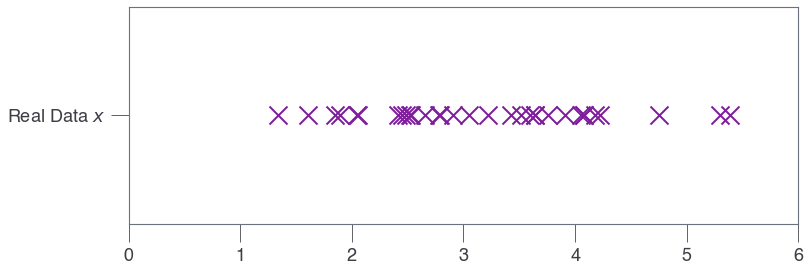

In [6]:
fig = figure(0, (12, 4)); ax=fig.add_subplot(111)
scatter(x.numpy(), np.zeros(len(x)), marker='x', c='xkcd:purple'); xlim([0, 6]); grid(0)
ax.get_yaxis().set_ticks([0]), ax.get_yaxis().set_ticklabels(['Real Data $x$']);

Now, let's create some fake data. We'll start with a sampling our random noise vector $z$ from gaussian distribution. Something we haven't discussed yet is that **we get to choose the size of z**. In this case, since we're trying to build the world's simplest GAN, we'll start with a z dimension of 1. Just as with our real data, we'll sample a batch of size $n$. It's worth noting that z is often called a **latent variable** in the context of GANs, and when we make changes to our random vector $z$, this is often referred to as working in the "latent space". This interpretation will become more clear as we get deeper into GANs.

In [7]:
z = torch.randn(n) #32 examples of noise z. 
z

tensor([-0.3701, -1.6402, -1.0977,  0.8924,  0.3138, -0.6831, -1.4361,  1.0501,
         0.6669,  0.0335,  0.1992, -1.2549, -0.1772, -0.1853,  0.2511, -0.3429,
         0.1695,  0.4771,  1.2838, -1.1176,  0.1457,  2.0156, -1.2908, -0.6806,
        -0.0051, -0.7082,  1.9969, -1.1860, -0.8621, -1.0103,  0.1793,  1.8759])

Now, to create fake data, we need a generator function. In the spirit of keeping things simple, our generator function will just have one single parameter, we'll call it $b_G$, that we add to your input data. So $G(z)=z+b_G$. Generators in successful GANs are typically neural networks, but the only strict requirment here is that $G$ is differentiable. 

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.b = torch.tensor([0.0])
    def forward(self, x): return x+self.b

In [9]:
G = Generator() #We can now instantiate our Generator and create some fake data!
G(z)

tensor([-0.3701, -1.6402, -1.0977,  0.8924,  0.3138, -0.6831, -1.4361,  1.0501,
         0.6669,  0.0335,  0.1992, -1.2549, -0.1772, -0.1853,  0.2511, -0.3429,
         0.1695,  0.4771,  1.2838, -1.1176,  0.1457,  2.0156, -1.2908, -0.6806,
        -0.0051, -0.7082,  1.9969, -1.1860, -0.8621, -1.0103,  0.1793,  1.8759])

In [10]:
def vis_data(ax, G, x, z):
    scatter(x.numpy(), np.ones(len(x)), marker='x', c='xkcd:purple');
    scatter(G(z).numpy(), np.zeros(len(x)), marker='x', c='xkcd:sea blue'); xlim([-3, 5]); ylim([-1,2]); grid(0)
    ax.get_yaxis().set_ticks([0, 1]), ax.get_yaxis().set_ticklabels(['Fake Data $G(z)$', 'Real Data $x$']);

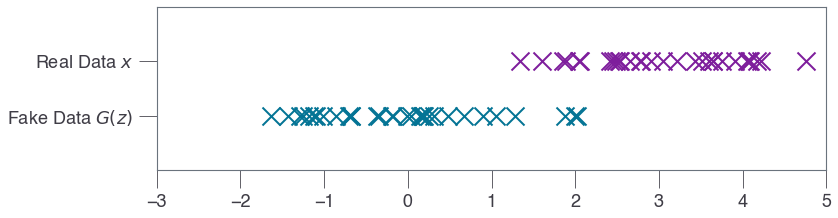

In [11]:
fig = figure(0, (12, 3)); ax=fig.add_subplot(111); 
vis_data(ax, G, x, z)

Alright, so we now have some real data $x$, and some fake data $G(z)$. Based on the plot above, how do you think our generator is doing? How good is our fake data? Let's see how changing our Generator parameter $b_G$ changes our fake data:

In [12]:
def play_with_generator(b=0):
    G.b.set_(torch.tensor(b,dtype=torch.float));
    fig = figure(0, (12, 3)); ax=fig.add_subplot(111)
    vis_data(ax, G, x, z)

In [13]:
interact(play_with_generator, b = (-4.0, 4.0))

interactive(children=(FloatSlider(value=0.0, description='b', max=4.0, min=-4.0), Output()), _dom_classes=('wi…

<function __main__.play_with_generator(b=0)>

Following the GAN approach here, we should use a discriminator function to seperate our real from fake examples. Again, instead of using a full-blown neural network here, we'll start with a really simple function:

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.b = torch.tensor([1.0])
    def forward(self, x): return torch.exp(-(x - self.b)**2)

In [15]:
D = Discriminator()

In [16]:
def vis_discriminator(ax, D):
    xs = torch.linspace(-5, 5, 100)
    ax.plot(xs.numpy(), D(xs).numpy(), c='xkcd:goldenrod')
    title('$D$')

In [17]:
def play_with_discriminator(b=0):
    D.b.set_(torch.tensor(b,dtype=torch.float));
    fig = figure(0, (12, 6)); ax=fig.add_subplot(111)
    vis_discriminator(ax, D); 

In [18]:
interact(play_with_discriminator, b = (-4.0, 4.0))

interactive(children=(FloatSlider(value=0.0, description='b', max=4.0, min=-4.0), Output()), _dom_classes=('wi…

<function __main__.play_with_discriminator(b=0)>

As you can see, our discriminator is a really simple bell-shaped curve with one parameter that shifts our curve to the left or right: $D(x)=e^{-(x-b_D)^2}$. Remember that our discriminator is supposed to return the probability that an an input example $x$ is real. In the case of our super simple discriminator, the closer our input $x$ is to our single discriminator parameter $b_D$, the higher the returned probability of x being real is, reaching a maximum value of 1 when $x=b_D$. Now that we've chosen functions for our discriminator and generator, let's think about how whole systems works. 

$$ D(x)=e^{-(x-b_D)^2} $$
$$ G(z)=z+b_G$$ 
$$
\min_G \max_D V(D, G)=
\mathbb{E}_{x\sim p_{data}(x)}[\log D(x)]
+ \mathbb{E}_{z\sim p_z(z)}[\log(1 - D(G(z)))]
$$

In [19]:
def probe_value_function(D, G, x, z):
    bs = torch.linspace(-1, 7, 64)
    V = torch.zeros((len(bs), len(bs)))
    for i, bG in enumerate(bs):
        G.b.set_(bG)
        for j, bD in enumerate(bs):
            D.b.set_(bD) 
            V[i, j] = torch.mean(D(x)) + torch.mean(1-D(G(z))) #Ignore logs in value function for now
    return meshgrid(bs, bs), V

In [20]:
def vis_value_function(ax, grids, V, bd=None, bg=None):
    f=contourf(*grids, V); grid(0); colorbar();
    if (bd, bg) is not (None, None): ax.scatter(bd, bg, color=(1, 0, 1), s=50)
    title('$V(D, G)$'); xlabel('$b_D$'); ylabel('$b_G$'); 

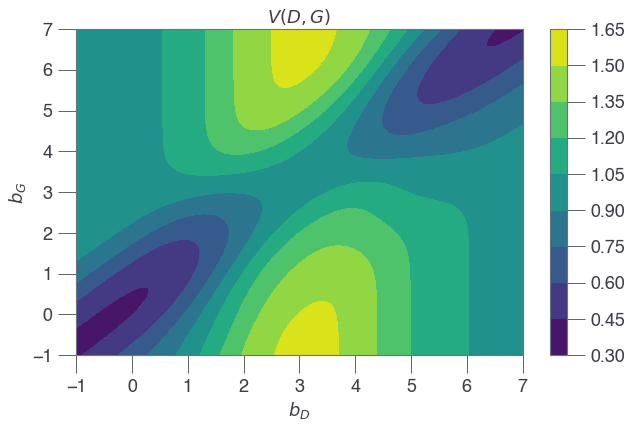

In [21]:
grids, V = probe_value_function(D, G, x, z)
vis_value_function(ax, grids, V)

In [22]:
def play_with_gan(bd=0, bg=0):
    G.b.set_(torch.tensor(bg,dtype=torch.float));
    D.b.set_(torch.tensor(bd,dtype=torch.float));
    gs = gridspec.GridSpec(3, 2)
    fig = figure(0, (18, 6)); ax=fig.add_subplot(gs[:2, 0]); vis_discriminator(ax, D)
    ax=fig.add_subplot(gs[2, 0]); vis_data(ax, G, x, z)
    ax=fig.add_subplot(gs[:, 1]); vis_value_function(ax, grids, V, bd, bg)

In [23]:
interact(play_with_gan, bd=(-4.0, 4.0), bg=(-4.0, 4.0));

interactive(children=(FloatSlider(value=0.0, description='bd', max=4.0, min=-4.0), FloatSlider(value=0.0, desc…

$$
\min_G \max_D V(D, G)= \frac{1}{m} \sum_{i=1}^{m} D(x_i)
+ \frac{1}{m} \sum_{i=1}^{m} \big( 1 - D(G(z_i))) \big)
$$

Let's try to get a sense for Goodfellow's equation using our interactive plot. Note that we've removed the logs from Goodfellow's equation to make the visual more clear - the logs are mostly here for computational reasons - the logs make computing these values on a computer easier, but do not change the solution to the equation. Remember what Goodfellow's equation is asking us to do two things at once: 1. Find the generator $G$ that minimizes $V$. 2. Find the discriminator $D$ that maximizes $V$. In Goodfellows original formulation, $G$ and $D$ are expressed as arbitrary functions. However, in practice (as Goodfellow goes on to layout in his paper), we fix $D$ and $G$ to be some specific functions (like a specific neural network), and search for the parameters of our functions, instead of searching accross all functions (because we have no tractible way of doing this!). For us, since we've chosen really simple functions that only have one parameter each, we only have two parameters to tune! 

Notice how changing each of our variables, changes our plot above, especially the value function (the magenta point) in the value function plot to the right. Let's try to achieve what Goodfellow's equation is asking us to do manually. Let's start with the $max_D$ part, if we adjust our Discriminator parameter $b_D$, notice that as we increase $b_D$, our dicriminator curver moves more on top of our data, increasing the value of $\frac{1}{m} \sum_{i=1}^{m} D(x_i)$, while moving away from our fake data, decreasing the value of $\frac{1}{m} \sum_{i=1}^{m} D(G(z_i))$. The next effect here is to increase our value function. We can see this clearly on our heatmap plot, reaching a maximum around $D_b=3$. Alright, so we've done half of what Goodfellow has asked us to do! For at least this one Generator we've found $\max_D V(D, G)$ by setting $b_D$ to approximately 3. 

Now, of course, we're only half way there! Let's now consider the $max_G$ part of Goodfellow's equation. This part asks us to find the valug of $b_G$ that *minimizes* V. If we start fiddling with $b_G$, notice that increasing $b_G$ brings our value function down. This is becuase we're moving more of our fake data beneath the large valued parts of our discriminator, increasing the value of $\frac{1}{m} \sum_{i=1}^{m} D(G(z_i))$, decreasing $V$, and "fooling" our discriminator with more realistic fake data! $V$ reaches a minimum when $b_G$ is around 3, by no coincidence, right when our fake data ends up directly below our discriminator curve!

Ok, so with our "brute force" method, we've solved goodfellow's equation! We've found a Discriminator configuration that maximimizes $V$, while simultaneously finding a Generator configuration that minimizes $V$. Pretty cool, right?

This type of solution is called a **Nash Equibrium**, becuase we've found a solution where if either player **unilaterally** changes their strategy, they will be worse off. In the parameter space of our value function, Nash equibruim look like saddle points! So while in most machine learning problems we're looking for local (or global :)) minima, with GANs we're looking for something different. We're looking for points in the paremeter space where our functions are **in balance.**. We're looking for Nash Equilibria. 

Now, a good follow up question is...why? Why do we care about finding Nash Equilibria in the parameter space of this value function? Well, as we mentioned at the beginning of this lecture, it turns out that if you're able to find this solution, to solve Goodfellow's equation, **your fake data will be indistinguishable from your real data**. That is, as Goodfellow goes on to prove in his paper, if you find this solution, the fake data the comes our of your Generator will have the same exact probability distribution as your real data. 

This is pretty boring in one dimension as in the example above, but in the case high dimenional data, such as images - this result is remarkable. Now, before we get too excited here, there's a couple of cavaets. For one, Goodfellow's proof only holds up for the set of continuous functions, not for parameterized functions like neural networks. But more importantly, **we haven't figured out how to find these Nash Equilibria in the general case!** In our toy example above, we found the solution by hand - a strategy that definitely won't work in many dimensions over 2!

Fortunately, Goodfellow also presents a computationally feasible strategy for finding these Nash Equilibria:

![](../graphics/goodfellow_alg_one-01.png)

Let's spend some time breaking down goodfellow's algorithm. First, in the algorithm description, notice that Goodfellow is proposing we use stochastic gradient descent to find a solution to our equation, just as we do when training supervised neural networks. So the idea is we'll take lots of small steps along the gradients or our Discrimiantor and Generator (with respect to their parameters). Specifically, we start by sampling a "minibatch of noise", and a minibatch from the data generating distribution $p_{data}(x)$. In practice, this just means that we need to take a random sample of example from our dataset, just as we do when training an supervised neural network. After sampling our data, we compute the gradient of our value function with respect to our discriminator parameters, and use this gradient to update our discriminator parameters. Next, we sample another "random minibatch", and computer the gradient of our value function again, but this time with repsect to our Generator parameters. Notice that Goodfellow has ommitted the $log D(x^{(i)})$ from the value function when computing the gradient of our generator - hopefully this makes sense - this term would be $0$, becuase changing our generator parameters has no impact on our real data $x$. Let's implement Goodfellow's algorithm in PyTorch!

In [24]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.b = nn.Parameter(torch.tensor([0.0])) #Making this an nn.Parameter now, gradient will be computed
    def forward(self, x): return x+self.b

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.b = nn.Parameter(torch.tensor([1.0]))
    def forward(self, x): return torch.exp(-(x - self.b)**2)

In [26]:
num_steps=512; lr=0.1 #Let's run goodfellow algorithm for num_steps at a learning rate of lr

D=Discriminator(); G=Generator()
n = 32 #How many examples do we want?
x = torch.randn(n) + 3 #"Real" Data for now, in practice this will be our real data. 
z = torch.randn(n) #Note that goodfellow's algorithm says we should re-sample this each time, for now, we'll just sampel once.

In [27]:
params = {'G':[],'D':[]} #Keep track of parameters while training

for i in tqdm(range(num_steps)):
    #Train Discriminator
    V=torch.mean(D(x)) + torch.mean(1-D(G(z))) #Leave logs out for now.
    V.backward() #Perform backprop
    with torch.no_grad():
        D.b+=D.b.grad*lr #Gradient Ascent
    params['D'].append(D.b.item()) #Log Paremeters
    D.zero_grad(); G.zero_grad();
    
    #Train Generator
    V=torch.mean(1-D(G(z))) #Leave logs out for now.
    V.backward() #Perform backprop
    with torch.no_grad():
        G.b-=G.b.grad*lr #Gradient Descent
    params['G'].append(G.b.item()) #Log Paremeters
    D.zero_grad(); G.zero_grad(); 

100%|██████████| 512/512 [00:00<00:00, 1806.00it/s]


In [28]:
with torch.no_grad():
    grids, V = probe_value_function(D, G, x, z)

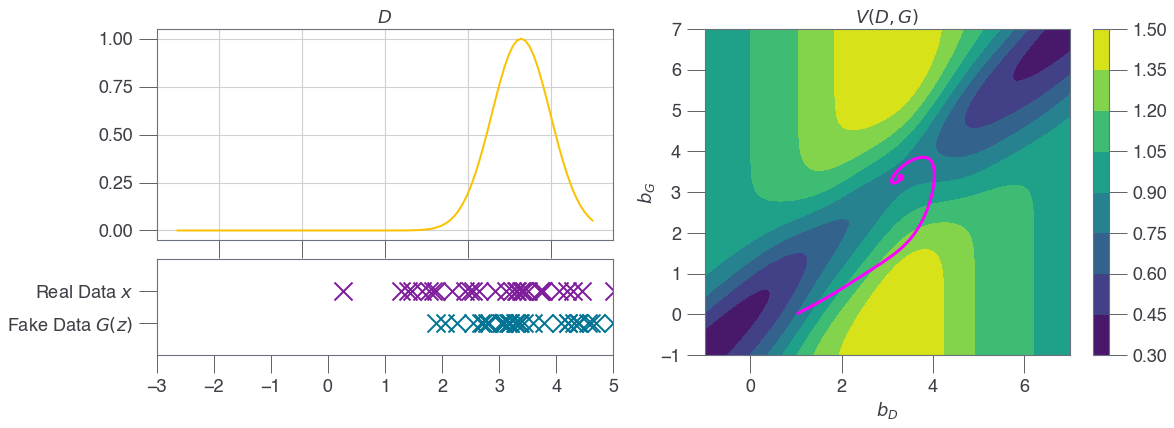

In [29]:
gs = gridspec.GridSpec(3, 2)
fig = figure(0, (18, 6)); ax=fig.add_subplot(gs[:2, 0]); 
with torch.no_grad(): 
    D.b.set_(torch.tensor(params['D'][i]))
    vis_discriminator(ax, D)

ax=fig.add_subplot(gs[2, 0]); 
with torch.no_grad(): 
    G.b.set_(torch.tensor(params['G'][i]))
    vis_data(ax, G, x, z)

ax=fig.add_subplot(gs[:, 1]); vis_value_function(ax, grids, V)
plot(params['D'][:i+1], params['G'][:i+1], color=(1,0,1), linewidth=3)
scatter(params['D'][i], params['G'][i], color=(1,0,1), s=50)

Alright, as you can see above, using goodfellow's algorithm, we found the Nash Equilibrium in our value function! Further, our fake data distribution has been shifted by our generator to be close to our real data. Let's watch Goodfellow's algorithm in action:

![](../videos/1d_gan_a.gif)

![](../graphics/spacer_small.png)

### And of course, in 3D :)

![](../videos/1d_gan_b.gif)

Pretty cool, right!? We've built a really simple GAN. As you can see, using Goodfellow's Gradient Descent algorithm, we have found our Nash equilibrium, and our fake data disribution looks pretty close to our real data! Now, this of course just really simple a 1-dimensional example - we could have solved this problem with much simpler methods! But what's really remarkable is how well **Goodfellow's approach scales to higher dimensional data.** We'll explore this next. 

![](../graphics/spacer_small.png)

## 3. A Dive into Higher Dimensions
---

Alright, so we've seen how to apply Goodfellow's algorithm in one dimension - now our job is to apply Goodfellow's appraoch to much more interesting, higher dimensional data. Let's start with a relatively simple dataset, the MNIST handwritten digit dataset.  

### 3.1 The Data

In [31]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
#Let's automate some data loading with fastai vision (a torchvision replacement)
from fastai.vision import *
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #Do we have a GPU?
defaults.device = device
print(device)

cpu


We'll use the super handy [ImageDataBunch](https://docs.fast.ai/vision.data.html#ImageDataBunch) from fastai to handle our data. We'll also go ahead and choose a batch size, and normalize our data> 

In [33]:
batch_size, im_size, channels = 128, 32, 1

path = untar_data(URLs.MNIST)
tfms = ([*rand_pad(padding=3, size=im_size, mode='zeros')], [])
data = ImageList.from_folder(path, convert_mode='L').split_none() \
                                                    .label_empty() \
                                                    .transform(tfms, size = im_size) \
                                                    .databunch(bs=batch_size)

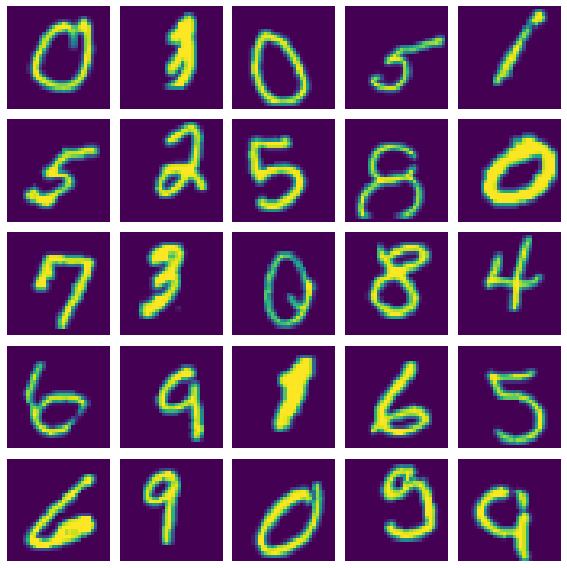

In [34]:
data.show_batch(figsize=(8, 8))

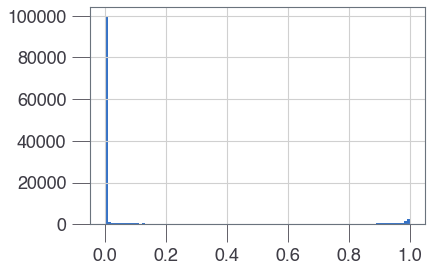

In [35]:
x, y=data.one_batch()
hist(x.numpy().ravel(),100);

### 3.2 Model Architecture

As you may have guessed, our simple 1-parameter models from our Toy GAN really aren't going to cut it here. We need a more sophisticated generator and discriminator to make fake handwritten digits. We'll use an architecture similar to the architecture Goodfellow used in his original work.

In [36]:
import torch
import torch.nn as nn

#### 3.2.1 Generator

Our generator may look different than the neural networks you may have seen before. The reason for this is that, unlike most neural networks that map from high-dimension to low-dimensional space (e.g. 224x224x3 color images to 10 discrete classes), our Generator needs to map from a low-dimensional random noise vector to a higher dimensional image. Goodfellow used random noise vectors of length, and for the most part, researchers continue to use noise vectors around this size. The challenge here is that we would like to map from smaller to bigger images, would still like to use convoultions for the speed, efficiency, and proven effectiveness, but the traditional convolution gives us no means of producing a larger image than we started with. 

Fortunatley, someone much smarter than me has already thought of this, and developed a method for doing exactly this: **transposed** or **fractionally strided** convolutions. There's a [terrific paper](https://github.com/vdumoulin/conv_arithmetic) on this by Vincent Dumoulin and Francesco Visin, I've borrowed an animation from their work below.

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="../graphics/no_padding_no_strides_transposed.gif"></td>
    <td><img width="150px" src="../graphics/arbitrary_padding_no_strides_transposed.gif"></td>
    <td><img width="150px" src="../graphics/same_padding_no_strides_transposed.gif"></td>
    <td><img width="150px" src="../graphics/full_padding_no_strides_transposed.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides, transposed</td>
    <td>Arbitrary padding, no strides, transposed</td>
    <td>Half padding, no strides, transposed</td>
    <td>Full padding, no strides, transposed</td>
  </tr>
  <tr>
    <td><img width="150px" src="../graphics/no_padding_strides_transposed.gif"></td>
    <td><img width="150px" src="../graphics/padding_strides_transposed.gif"></td>
    <td><img width="150px" src="../graphics/padding_strides_odd_transposed.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides, transposed</td>
    <td>Padding, strides, transposed</td>
    <td>Padding, strides, transposed (odd)</td>
    <td></td>
  </tr>
</table>

In [37]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.ReLU(inplace = True))

In [38]:
G = nn.Sequential(
    conv_trans(100, 512, ks=4, stride=1, padding=0), 
    conv_trans(512, 256), 
    conv_trans(256, 128),
    nn.ConvTranspose2d(128, channels, 4, stride=2, padding=1),
    nn.Sigmoid()).to(device)

torch.Size([128, 1, 32, 32])

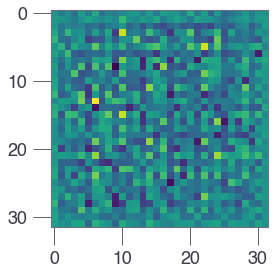

In [39]:
z = torch.randn(batch_size, 100, 1, 1)
fake = G(z.to(device))
imshow(fake[0, 0].cpu().detach().numpy()); grid(0)
fake.shape

So there you have it, a fake image! Doesn't look to convincing yet, but of course, we haven't trained our GAN yet!

#### 3.2.2 Disciminator

Our discriminator will be much closer to the deep models we've seen before, we'll use 4 convolutional layers. 

In [40]:
def conv(ni, nf, ks=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=padding), 
        nn.ReLU(inplace = True))

In [41]:
D = nn.Sequential(
    conv(channels, 128), 
    conv(128, 256), 
    conv(256, 512), 
    nn.Conv2d(512, 1, 4, stride=1, padding=0), 
    Flatten(), 
    nn.Sigmoid()).to(device)

In [42]:
D(fake).shape

torch.Size([128, 1])

### 3.3 Training Loop

In [43]:
from torch import optim
from tqdm import tqdm
from IPython import display
import matplotlib.gridspec as gridspec

In [44]:
def show_progress():
    '''Visualization method to see how were doing'''
    clf(); fig = figure(0, (24, 12)); gs = gridspec.GridSpec(6, 12)
    with torch.no_grad(): fake = G(z_fixed)
    for j in range(30):
        fig.add_subplot(gs[(j//6), j%6])
        imshow(fake[j, 0].detach().cpu().numpy(), cmap='gray'); axis('off')
    ax=fig.add_subplot(gs[5, :4]); hist(fake.detach().cpu().numpy().ravel(), 100, facecolor='xkcd:crimson')
    ax.get_yaxis().set_ticks([]); xlabel('$G(z)$'); xlim([-1, 1])
    ax=fig.add_subplot(gs[5, 4:7]); hist(x.cpu().numpy().ravel(), 100, facecolor='xkcd:purple')
    ax.get_yaxis().set_ticks([]); xlabel('$x$')
    fig.add_subplot(gs[:,7:])
    plot(losses[0], 'xkcd:goldenrod'); plot(losses[1], color='xkcd:sea blue'); legend(['Discriminator', 'Generator'],loc=1); 
    grid(1); title('Epoch = ' + str(epoch)); ylabel('loss'); xlabel('iteration');
    display.clear_output(wait=True); display.display(gcf())

Unlike our toy example, intead of regular SGD we're going to use the **Adam Optimizer**. We'll use a seperate optimizer PyTorch optimizer for our discriminator and generator:

In [45]:
optD = optim.Adam(D.parameters(), lr=2e-4, betas = (0.5, 0.999))
optG = optim.Adam(G.parameters(), lr=2e-4, betas = (0.5, 0.999))

Now, we need to make a few more changes to our Toy GAN. First, we need to spend a little time on the **Value Function**. In practice, our Toy GAN will struggle to learn on real data becuase of the way our value function behaves when our generator creates very bad fake data. Goodfellow points this out in his original publication. The idea here is that the Generator loss function saturates when $D(G(z))$ is close to zero, and does not provide much gradient to learn from. Goodfellow proposes a Hueristic solution, replacing $log(1-D(G(z)))$ with $-log(D(G(z)))$. Both curves monotonically decrease as $D(G(z))$ increases, but $-log(D(G(z)))$ gives us a much stronger gradient when $D(G(z))$ is close to zero (helping our generator learn more quickly when its predictions are very different from real data). 

![](../graphics/Hueristic_GAN_Loss-01.png)

Finally, before we train our GAN, we need to be a little careful about how we implement our loss function. Instead of directly implementing our loss function explicitly in pytorch as `torch.mean(torch.log(D(G(z))) + torch.mean(torch.log(1-D(G(z)))`, we'll use PyTorch's [`nn.BCELoss()`](https://pytorch.org/docs/stable/nn.html#bceloss). `nn.BCELoss` is more stable computationally, and in my experience can really make the difference between a model that converges and one that doesn't. To use `nn.BCELoss`, we'll break up the cost function into two parts, on for our real data and one for our fake data, and add these two parts together before taking our gradient. This is where libraries like PyTorch realy shine, just as a results of us adding the two parts of our loss function together, Pytorch knows how to backpropogate errors to each portion of our loss function!

It's worth taking some time walking thought the training code below to make sure each step makes sense. We'll visualize our GAN performance as we train. Measing and Visualizing GAN Performance can be difficult, becuase there's not unique measure of how realistic our fake data is (If there was, we could just optimize this directly!). For this reason, it's become popular to visualize generated images during traininng to get an idea of how our GAN is doing. We'll do this for a fixed set of latent vectors, `z_fixed`, visualizing the output of our generator from a fixed set of inputs will make our training animation easier to follow. We'll also visualize the distribution of a batch of our training and synthetic data, and finally, we'll plot our discriminator and generator loss functions. Note that in Goodfellow's original GAN formulation, our Discriminator and Generator loss were the same quantity (The value function)! But our modified formulation means that our Generator loss is a bit different than our Discrminator loss. However, our losses still quantify opposing goals, so a lower discriminator loss will correspond to a higher generator loss and vice versa. 

In [46]:
criterion = nn.BCELoss()
zero_labels = torch.zeros(batch_size).to(device)
ones_labels = torch.ones(batch_size).to(device)
epochs, viz_freq = 1, 50
z_fixed = torch.randn(batch_size, 100, 1, 1).to(device) #Let's use a fixed latent vector z for viz

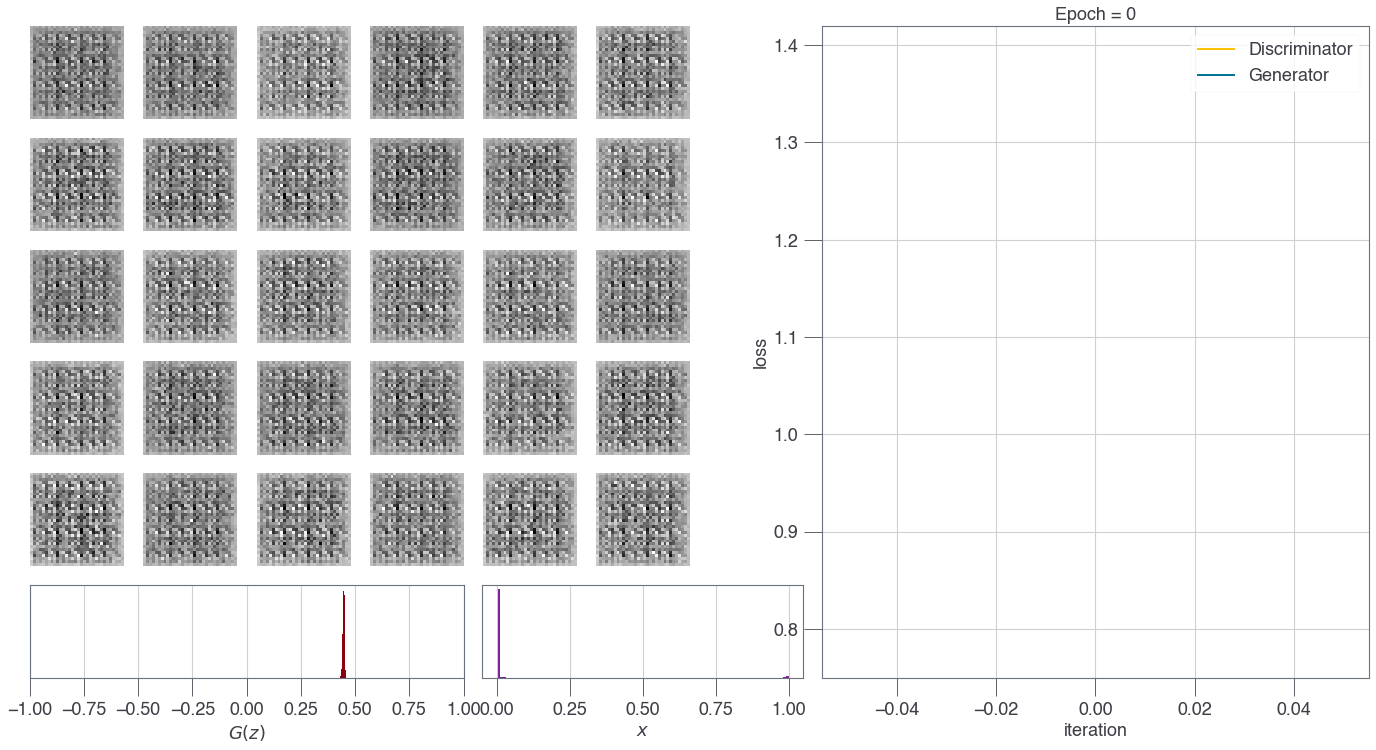

  1%|          | 3/546 [00:12<39:52,  4.41s/it]

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

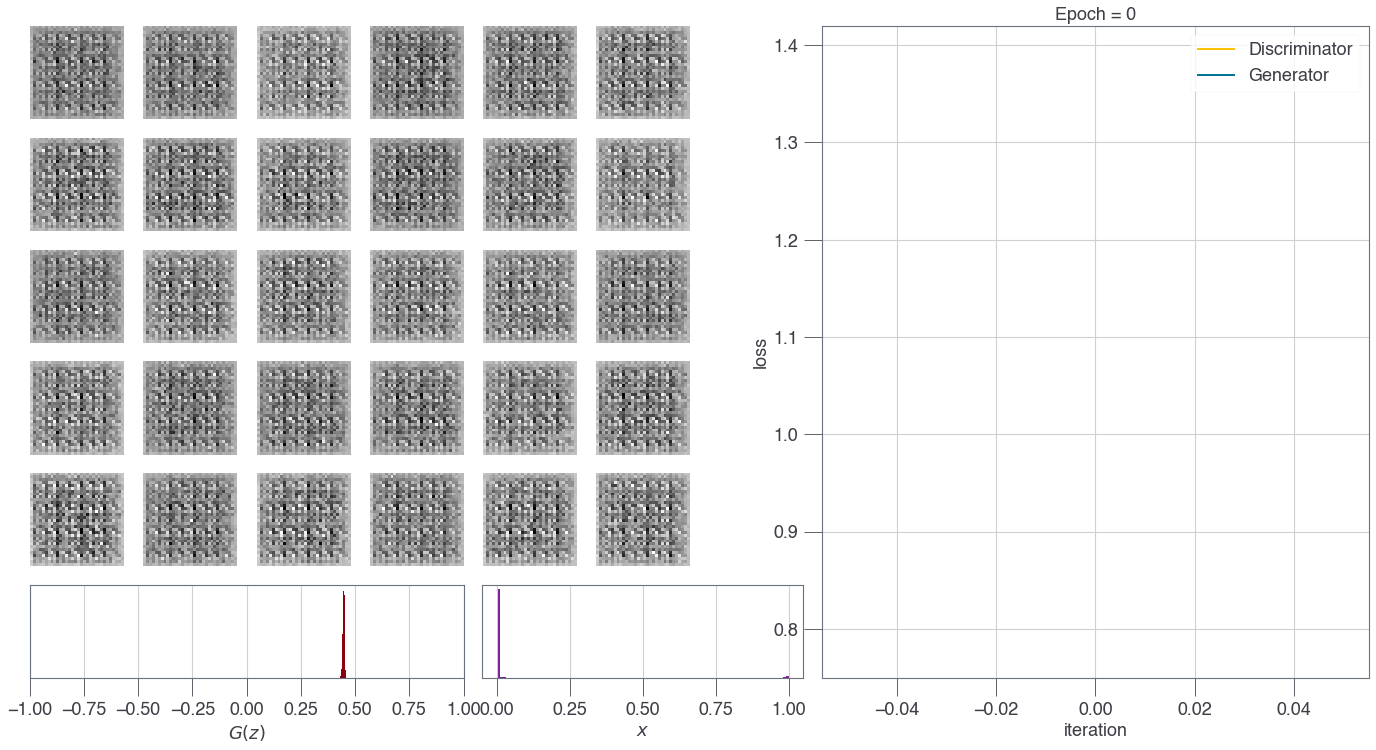

In [47]:
losses = [[],[]] #Keep track of losses

for epoch in range(epochs):
    for i, (x,y) in enumerate(tqdm(data.train_dl)):
        #Train Discriminator
        requires_grad(G, False); #Speeds up training a smidge
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        l_fake = criterion(D(G(z)).view(-1), zero_labels) 
        l_real = criterion(D(x).view(-1), ones_labels)
        loss = l_fake + l_real
        loss.backward(); losses[0].append(loss.item())
        optD.step(); G.zero_grad(); D.zero_grad(); 

        #Train Generator
        requires_grad(G, True);
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        loss = criterion(D(G(z)).view(-1), ones_labels)
        loss.backward(); losses[1].append(loss.item())
        optG.step(); G.zero_grad(); D.zero_grad();
        
        if i%viz_freq == 0: show_progress()

This can be pretty slow on a cpu machine, here's an animation of our GAN training:

![](../videos/goodfellow_gan_fail.gif)

Note that the 30 images in our animation are supposed to show our fake data! As you likeley noticed, these look nothing like realy handwritten digits. Our GAN is not creating realistic fake data. Notice that our Discriminator and Generator stop learning after a little while, and our generated images just look black! So, what's going on here? 

Well, it turns out that GANs, especially the early variants, are notoriously difficult to train. While Goodfellow's paper provides some convergence gaurantees for GANs in theory, these are only true in the space of truly continuous functions, not pareterized functions like our Neural Networks. 

Fortunately, since the publication of Goodfellow's idea, a large amount of effort has gone into creating more stable varients GANs. One of the first improvments, DCGAN, was published in 2015 by [Alec Radford, Luke Metz, Soumith Chintala.](https://arxiv.org/abs/1511.06434) 

## 4. DCGAN to the Rescue
---

![](../graphics/DCGAN_overview-01.png)

In late 2015, published what is know known as DCGAN, one of the first GANs that could be trained by a mere mortal. Perhaps their most valuable contribution are the above guidlines for training GANs. Like alot of deep learning research, these GAN recommendations appear to be largeley based on empirical investigations - really "tricks of the trade" that work well in practice. 

Let's apply these Architecture guidelines to our GAN! We'll also borrow the generator architecture that the DCGAN authors use for the LSUN Bedroom dataset:

![](../graphics/dc_gan-01.png)

First, we'll change our image size to 64x64 to match the architecture used in the DCGAN paper, this is really easy with fastai. We'll also normalize our data to be between -1 and 1. We're doing this becuase, following the DCGAN paper, we're going to use a Tanh function on the output of our generator, making our synthetic images values fall between -1 and 1 (we used a sigmoid function in our first generator).

In [48]:
batch_size, im_size, channels = 128, 64, 1

path = untar_data(URLs.MNIST)
tfms = ([*rand_pad(padding=3, size=im_size, mode='zeros')], [])
data = ImageList.from_folder(path, convert_mode='L').split_none() \
                                                    .label_empty() \
                                                    .transform(tfms, size = im_size) \
                                                    .databunch(bs=batch_size) \
                                                    .normalize((0.5, 0.5))

Next, we'll add Batch Normalization to our Generator and Discriminator. [Batch Normalization](https://arxiv.org/pdf/1502.03167.pdf) is a simple but very effective technique for normalizing our data as it passes through our network, speeding up training, and sometimes making triaining more stable and improving generalization. Since it's introduction in 2015, Batch Normalization has become common practice in deep models. 

In [49]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.BatchNorm2d(nf), 
        nn.ReLU(inplace = True))

In [50]:
G = nn.Sequential(
    conv_trans(100, 1024, ks=4, stride=1, padding=0), 
    conv_trans(1024, 512), 
    conv_trans(512, 256),
    conv_trans(256, 128),
    nn.ConvTranspose2d(128, channels, 4, stride=2, padding=1),
    nn.Tanh()).to(device)

In [51]:
def conv(ni, nf, ks=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=padding), 
        nn.BatchNorm2d(nf), 
        nn.LeakyReLU(0.2, inplace = True))

In [52]:
D = nn.Sequential(
    conv(channels, 128), 
    conv(128, 256), 
    conv(256, 512), 
    conv(512, 1024), 
    nn.Conv2d(1024, 1, 4, stride=1, padding=0), 
    Flatten(), 
    nn.Sigmoid()).to(device)

Alright, after all that work, we're ready to train our DCGAN. 

In [53]:
zero_labels = torch.zeros(batch_size).to(device)
ones_labels = torch.ones(batch_size).to(device)
losses = [[],[]]
epochs, viz_freq, count = 1, 25, 0
z_fixed = torch.randn(batch_size, 100, 1, 1).to(device)

for epoch in range(epochs):
    for i, (x,y) in enumerate(tqdm(data.train_dl)):
        #Train Discriminator
        requires_grad(G, False); #Speeds up training a smidge
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        l_fake = criterion(D(G(z)).view(-1), zero_labels)
        l_real = criterion(D(x).view(-1), ones_labels)
        loss = l_fake + l_real
        loss.backward(); losses[0].append(loss.item())
        optD.step(); G.zero_grad(); D.zero_grad(); 

        #Train Generator
        requires_grad(G, True);
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        loss = criterion(D(G(z)).view(-1), ones_labels)
        loss.backward(); losses[1].append(loss.item())
        optG.step(); G.zero_grad(); D.zero_grad();
        
        if i%viz_freq == 0: show_progress()
        count+=1


  0%|          | 0/546 [00:00<?, ?it/s]

KeyboardInterrupt: 

---

And a faster animation of the same model:

![](../videos/dcgan_mnist.gif)

Not, bad right?! I think the beginning of this training is really really cool, let's watch it a bit slower.

![](../videos/dcgan_mnist_slowmo.gif)

As you can see, for the first 100 iterations or so, our discriminator completeley "wins". During this time, our generator hops around randomly until, around iteration 100 it finds some simple examples that fool the discriminator! From there, the generator and discriminator battle back and forth, making our synthetic images better and better in the process. Finally, here's the same architecture trained on the LSUN bedroom dataset:

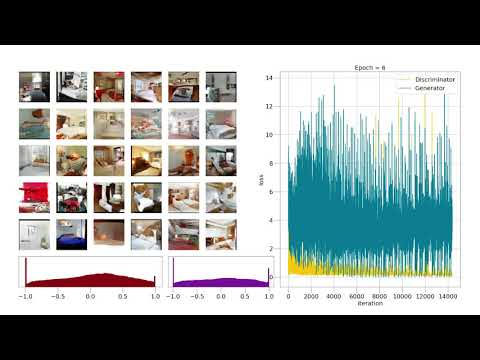

In [54]:
from IPython.display import YouTubeVideo
YouTubeVideo('xxXbJ8-XmHU', width=1000, height=562)

## 6. GANs Grow Up (Sortof)
---

1. [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)
2. [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf)
3. [Improved Wasserstain GAN](https://arxiv.org/pdf/1704.00028.pdf)
4. [BigGAN](https://arxiv.org/pdf/1809.11096.pdf)
5. [Progressive GAN](https://arxiv.org/pdf/1710.10196.pdf)
6. [Style GAN](https://arxiv.org/pdf/1812.04948.pdf)

## 7. StyleGAN Insanity

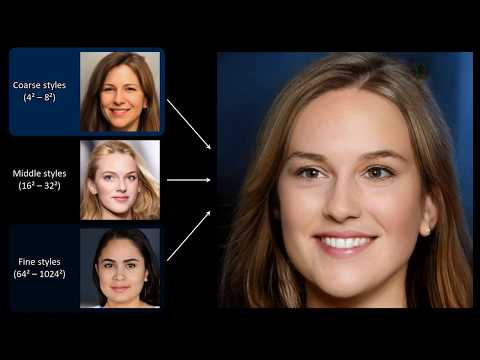

In [55]:
from IPython.display import YouTubeVideo
YouTubeVideo('kSLJriaOumA', width=1000, height=562)

## 8. The Unbelievably Interesting World of GAN Variants

1. [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf)
1. [SRGAN](https://arxiv.org/pdf/1609.04802.pdf)
1. [GANerated Hands](https://handtracker.mpi-inf.mpg.de/projects/GANeratedHands/)
1. [GANs for unsupervised depth estimation](https://arxiv.org/pdf/1808.07528.pdf)
1. [Stack GAN](https://arxiv.org/pdf/1710.10916.pdf)